## Step 1.1 — Problem Statement

The COVID-19 pandemic has had a profound global impact, but its effects have varied significantly across countries.  
In this project, I aim to analyze how population size influences the total COVID-19 burden (cases and deaths) and identify countries that were disproportionately affected.  

To achieve this, I will wrangle two datasets: a manually downloaded CSV containing daily COVID-19 case and death data, and population data obtained programmatically via the World Bank API.  
By combining these sources, I will investigate proportional impacts (cases and deaths per million people) to better understand the role of population in shaping pandemic outcomes.


# **Necessary imports**

In [4]:
# Import core libraries for data analysis and visualization

import pandas as pd        # for data manipulation and analysis
import numpy as np         # for numerical operations
import matplotlib.pyplot as plt  # for static visualizations
import seaborn as sns      # for advanced statistical visualizations
import os

# Install and import requests for API calls
try:
    import requests
    print("✓ requests module imported successfully")
except ImportError:
    print("Installing requests module...")
    import subprocess
    import sys
    subprocess.check_call([sys.executable, "-m", "pip", "install", "requests"])
    import requests
    print("✓ requests module installed and imported successfully")


✓ requests module imported successfully


In [5]:
# Verify all required modules are available
print("Module verification:")
print(f"✓ pandas version: {pd.__version__}")
print(f"✓ numpy version: {np.__version__}")
print(f"✓ matplotlib version: {plt.matplotlib.__version__}")
print(f"✓ seaborn version: {sns.__version__}")
print(f"✓ requests version: {requests.__version__}")
print("✓ os module: built-in")
print("\nAll required modules are ready for data analysis!")

Module verification:
✓ pandas version: 2.3.1
✓ numpy version: 2.0.1
✓ matplotlib version: 3.10.0
✓ seaborn version: 0.13.2
✓ requests version: 2.32.5
✓ os module: built-in

All required modules are ready for data analysis!


# Confirm Dataset Location

Kaggle automatically stores uploaded/attached datasets inside the `/kaggle/input/` directory.  
To avoid hard-coding wrong paths, I will list all files in the input folder first.


In [6]:
# Walk through all files in the Kaggle "input" folder and print their paths
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Step 1.2: Load Dataset 1 (COVID-19 Global Data)

**Type**: CSV file (downloaded manually from Kaggle, originally scraped from Worldometers).  

**Method**: The dataset was gathered using the *manual download* method from Kaggle’s public datasets.  
It contains more than 180,000 rows of daily COVID-19 observations across 225 countries.  

**Key variables**:  
- `date` — Date of observation (YYYY-MM-DD)  
- `country` — Country name  
- `cumulative_total_cases` — Total confirmed cases to date  
- `cumulative_total_deaths` — Total confirmed deaths to date  
- `daily_new_cases` — New cases reported on that date  
- `daily_new_deaths` — New deaths reported on that date  
- `active_cases` — Number of active ongoing cases  

**Significance**:  
This dataset captures the spread of COVID-19 across countries and over time.  
It provides the necessary information to measure both absolute and relative impacts of the pandemic.

In [ ]:
covid_df = pd.read_csv("/kaggle/input/coronavirus/worldometer_coronavirus_daily_data.csv")

# Quick checks
print("Shape of dataset:", covid_df.shape)
covid_df.head()


# Step 1.2: Load Dataset 2 (World Bank Population Data via API)

*Type**: JSON API response (converted to DataFrame).  

**Method**: The dataset was gathered *programmatically* from the World Bank API using the indicator `SP.POP.TOTL`.  
To ensure more than 500 samples, I retrieved population counts for all countries over the years 2000–2020 (5,565 rows).  

**Key variables**:  
- `country` — Country name  
- `iso3` — ISO 3-letter country code  
- `year` — Observation year (2000–2020)  
- `population` — Total population of the country in that year  

**Significance**:  
Population is a crucial contextual variable for analyzing pandemic impacts.  
By combining this dataset with COVID-19 case and death counts, we can calculate proportional measures (cases per million, deaths per million) and fairly compare across countries of different sizes.


In [4]:
# Fetch population data from World Bank API for multiple years (2000-2020)
url = "http://api.worldbank.org/v2/country/all/indicator/SP.POP.TOTL"
params = {"format":"json", "date":"2000:2020", "per_page":"20000"}  # request multiple years
resp = requests.get(url, params=params)
resp.raise_for_status()
data = resp.json()

# Convert API response to DataFrame
pop_df = pd.DataFrame(data[1])

# Keep relevant columns
pop_df = pop_df[['country', 'countryiso3code', 'date', 'value']]
pop_df.columns = ['country', 'iso3', 'year', 'population']

# If country is stored as a dictionary, extract the "value" key
if isinstance(pop_df.loc[0, 'country'], dict):
    pop_df['country'] = pop_df['country'].apply(lambda c: c.get('value') if isinstance(c, dict) else c)

# Drop rows without population data
pop_df = pop_df.dropna(subset=['population'])

print("Shape of dataset:", pop_df.shape)
pop_df.head()


Shape of dataset: (5565, 4)


,country,iso3,year,population
0,Africa Eastern and Southern,AFE,2020,694446100.0
1,Africa Eastern and Southern,AFE,2019,675950189.0
2,Africa Eastern and Southern,AFE,2018,657801085.0
3,Africa Eastern and Southern,AFE,2017,640058741.0
4,Africa Eastern and Southern,AFE,2016,623369401.0


# Save Raw Datasets

In [5]:
# Save raw versions to working directory for reproducibility
covid_df.to_csv("/kaggle/working/covid_raw.csv", index=False)
pop_df.to_csv("/kaggle/working/population_raw.csv", index=False)

print("Raw datasets saved: covid_raw.csv, population_raw.csv")


Raw datasets saved: covid_raw.csv, population_raw.csv


## Step 2 — Assess the Data

In this step, I will inspect both datasets programmatically and visually to identify data quality and tidiness issues.  
The assessment will focus on:

- **Completeness** (missing values)  
- **Consistency** (naming and formatting)  
- **Validity** (are values realistic)  
- **Structure** (tidiness: one variable per column, one observation per row)

I will start by checking dataset summaries, data types, and missing values for each dataset.


# COVID dataset: structure, data types, missing values

In [6]:
# COVID dataset: structure, data types, missing values
print("COVID Dataset Info:")
print(covid_df.info())
print("\nMissing values per column:")
print(covid_df.isnull().sum().to_string())





COVID Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 184787 entries, 0 to 184786
Data columns (total 7 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   date                     184787 non-null  object 
 1   country                  184787 non-null  object 
 2   cumulative_total_cases   184787 non-null  float64
 3   daily_new_cases          174329 non-null  float64
 4   active_cases             166747 non-null  float64
 5   cumulative_total_deaths  178227 non-null  float64
 6   daily_new_deaths         157850 non-null  float64
dtypes: float64(5), object(2)
memory usage: 9.9+ MB
None

Missing values per column:
date                           0
country                        0
cumulative_total_cases         0
daily_new_cases            10458
active_cases               18040
cumulative_total_deaths     6560
daily_new_deaths           26937



# World Bank population dataset : structure, data types, missing values

In [7]:
# World Bank population dataset
print("Population Dataset Info:")
print(pop_df.info())
print("\nMissing values per column:")
print(pop_df.isnull().sum().to_string())


Population Dataset Info:
<class 'pandas.core.frame.DataFrame'>
Index: 5565 entries, 0 to 5585
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   country     5565 non-null   object 
 1   iso3        5565 non-null   object 
 2   year        5565 non-null   object 
 3   population  5565 non-null   float64
dtypes: float64(1), object(3)
memory usage: 217.4+ KB
None

Missing values per column:
country       0
iso3          0
year          0
population    0







### Step 2.1 — Data Quality & Tidiness Issues

From the quick inspection above, I identified the following issues:

**🔹 Quality Issue 1 — Missing values (COVID dataset)**  
- *Visual/programmatic evidence:* `daily_new_cases` has **10,458 missing values**, `active_cases` has **18,040**, `cumulative_total_deaths` has **6,560**, and `daily_new_deaths` has **26,937** missing values.  
- *Justification:* This reduces completeness and accuracy. Missing values can bias trend analysis, so they must be handled (e.g., imputation or removal).

**🔹 Quality Issue 2 — Inconsistent country entries (Population dataset)**  
- *Visual/programmatic evidence:* While no nulls exist, the dataset includes **aggregates** such as *“Arab World”*, *“Caribbean small states”*, and *“Africa Eastern and Southern”* that are not individual countries.  
- *Justification:* These aggregate regions will interfere with merging since they don’t correspond to actual countries in the COVID dataset.

---

**🔹 Tidiness Issue 1 — Date format (COVID dataset)**  
- *Visual/programmatic evidence:* The `date` column is stored as an **object (string)**.  
- *Justification:* Dates should be in datetime format for time-series analysis. Keeping them as strings restricts plotting and time-based filtering.

**🔹 Tidiness Issue 2 — Redundant variables / year storage (Population dataset)**  
- *Visual/programmatic evidence:* The `year` column is stored as a **string object**, not numeric or datetime.  
- *Justification:* This is inconsistent with proper data structure. It should be numeric or datetime type for filtering and merging with other time-based data.


## Step 3 — Clean the Data

In this step, I will apply cleaning strategies for the four issues identified in Step 2:

- **Quality Issue 1:** Missing values in COVID dataset  
- **Quality Issue 2:** Aggregate region entries in Population dataset  
- **Tidiness Issue 1:** Convert COVID `date` column to datetime  
- **Tidiness Issue 2:** Convert Population `year` column to numeric  

For each issue, I will:  
1. Apply the cleaning strategy  
2. Validate that it worked  
3. Provide a short justification


### Quality Issue 1 — Handle Missing Values

**Strategy:**  
For COVID data, `daily_new_cases` and `daily_new_deaths` can be imputed with **0** (because many days truly had no cases/deaths reported).  
For `active_cases` and `cumulative_total_deaths`, I will use **forward-fill** (carry previous value forward) since these are cumulative or running totals.

**Justification:**  
- Forward-fill is valid for cumulative counts.  
- Imputation with 0 is valid for daily counts where missing often means no reported change.  


In [8]:
# Make a working copy
covid_clean = covid_df.copy()

# Fill daily new cases/deaths with 0
covid_clean['daily_new_cases'] = covid_clean['daily_new_cases'].fillna(0)
covid_clean['daily_new_deaths'] = covid_clean['daily_new_deaths'].fillna(0)

# Forward-fill cumulative counts and active cases
covid_clean[['active_cases','cumulative_total_deaths']] = (
    covid_clean[['active_cases','cumulative_total_deaths']].fillna(method='ffill')
)

# Check missing values again
print("Missing values after cleaning:")
print(covid_clean.isnull().sum().to_string())


Missing values after cleaning:
date                       0
country                    0
cumulative_total_cases     0
daily_new_cases            0
active_cases               0
cumulative_total_deaths    0
daily_new_deaths           0


/tmp/ipykernel_117/2668327765.py:10: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  covid_clean[['active_cases','cumulative_total_deaths']].fillna(method='ffill')


### Quality Issue 2 — Remove Aggregate Regions

**Strategy:**  
Drop rows where `country` contains keywords like *“World”*, *“states”*, *“income”*, or *“region”* since these are **aggregates**, not actual countries.

**Justification:**  
Only keeping true countries ensures consistency and prevents incorrect merges later.


In [9]:
# Remove aggregates using keyword filter
keywords = ['world','region','income','states','union','area','caribbean','europe','africa','asia','pacific']
pop_clean = pop_df[~pop_df['country'].str.lower().str.contains('|'.join(keywords))].copy()

print("Shape after removing aggregates:", pop_clean.shape)
print("Sample entries after cleaning:")
print(pop_clean.head(10).to_string())


Shape after removing aggregates: (4788, 4)
Sample entries after cleaning:
                        country iso3  year    population
105  Early-demographic dividend  EAR  2020  3.396051e+09
106  Early-demographic dividend  EAR  2019  3.355015e+09
107  Early-demographic dividend  EAR  2018  3.314245e+09
108  Early-demographic dividend  EAR  2017  3.274060e+09
109  Early-demographic dividend  EAR  2016  3.233034e+09
110  Early-demographic dividend  EAR  2015  3.190319e+09
111  Early-demographic dividend  EAR  2014  3.146800e+09
112  Early-demographic dividend  EAR  2013  3.103677e+09
113  Early-demographic dividend  EAR  2012  3.058869e+09
114  Early-demographic dividend  EAR  2011  3.013477e+09


### Tidiness Issue 1 — Convert Date Column to Datetime

**Strategy:**  
Convert the `date` column from object/string into a proper `datetime` type.

**Justification:**  
Datetime format enables filtering, grouping, and time-series analysis.


In [10]:
# Convert date column to datetime
covid_clean['date'] = pd.to_datetime(covid_clean['date'], errors='coerce')

# Validate conversion
print("Data type of 'date' after conversion:", covid_clean['date'].dtype)
print("Earliest date:", covid_clean['date'].min())
print("Latest date:", covid_clean['date'].max())


Data type of 'date' after conversion: datetime64[ns]
Earliest date: 2020-01-22 00:00:00
Latest date: 2022-05-14 00:00:00


### Tidiness Issue 2 — Convert Year to Numeric

**Strategy:**  
Convert the `year` column in population data from string to integer.

**Justification:**  
Ensures proper comparison, filtering, and merging with other time-based datasets.


In [11]:
# Convert year column to integer
pop_clean['year'] = pop_clean['year'].astype(int)

# Validate conversion
print("Data type of 'year' after conversion:", pop_clean['year'].dtype)
print("Year range:", pop_clean['year'].min(), "-", pop_clean['year'].max())


Data type of 'year' after conversion: int64
Year range: 2000 - 2020


### Final Validation of Cleaned Datasets

Before proceeding to merging and storing (Step 4), I will re-check both cleaned datasets to ensure:  
- No unnecessary missing values remain  
- Data types are consistent  
- Structures look tidy and ready for analysis


In [12]:
print("COVID Clean Dataset Summary:")
print(covid_clean.info())
print("\nMissing values (COVID):")
print(covid_clean.isnull().sum().to_string())

print("\nPopulation Clean Dataset Summary:")
print(pop_clean.info())
print("\nMissing values (Population):")
print(pop_clean.isnull().sum().to_string())


COVID Clean Dataset Summary:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 184787 entries, 0 to 184786
Data columns (total 7 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   date                     184787 non-null  datetime64[ns]
 1   country                  184787 non-null  object        
 2   cumulative_total_cases   184787 non-null  float64       
 3   daily_new_cases          184787 non-null  float64       
 4   active_cases             184787 non-null  float64       
 5   cumulative_total_deaths  184787 non-null  float64       
 6   daily_new_deaths         184787 non-null  float64       
dtypes: datetime64[ns](1), float64(5), object(1)
memory usage: 9.9+ MB
None

Missing values (COVID):
date                       0
country                    0
cumulative_total_cases     0
daily_new_cases            0
active_cases               0
cumulative_total_deaths    0
daily_new_deaths           0

## Step 4 — Update Data Store

Now that both datasets are cleaned, I will merge them to create one analysis-ready dataset.

### Why filter for 2020 population?
The COVID dataset spans multiple years (2020–2022), but population values do not change drastically year to year.  
To avoid duplicates and inconsistencies, I select **2020 population values** as a stable baseline.  
This ensures that every daily COVID record can be paired with the correct population figure for proportional analysis.

### Key decisions made:
- Performed an **inner join** between `country` in the COVID dataset and `country` in the population dataset.  
- Retained key COVID variables (`cumulative_total_cases`, `daily_new_cases`, `cumulative_total_deaths`, etc.) and added population.  
- Dropped redundant columns to keep the structure tidy and easy to analyze.  
- Created multiple versions of the data:
  - **Raw datasets** (`covid_raw.csv`, `population_raw.csv`)  
  - **Cleaned datasets** (`covid_clean.csv`, `population_clean.csv`)  
  - **Merged dataset** (`covid_population_merged.csv`)  

### Why save multiple versions?
Maintaining raw, cleaned, and merged datasets ensures full **traceability and reproducibility**.  
This allows me (or anyone reviewing the project) to go back to earlier stages if needed and validates that cleaning steps were done correctly.


In [13]:
# ----- Step 4: Merge and Store Cleaned Data -----

# Filter population data to only 2020 values
pop_2020 = pop_clean[pop_clean['year'] == 2020].copy()

# Merge COVID dataset with 2020 population data
merged = covid_clean.merge(
    pop_2020[['country', 'iso3', 'population']],
    on='country',
    how='inner'
)

# Rename columns for clarity
merged = merged.rename(columns={
    'iso3': 'ISO3',
    'population': 'Population_2020'
})

# Inspect merged dataset
print("Merged dataset shape:", merged.shape)
print("Columns:", merged.columns.tolist())
print("\nSample merged rows:")
print(merged.head(10).to_string())

# Save raw, cleaned, and merged datasets
covid_df.to_csv("covid_raw.csv", index=False)
pop_df.to_csv("population_raw.csv", index=False)
covid_clean.to_csv("covid_clean.csv", index=False)
pop_clean.to_csv("population_clean.csv", index=False)
merged.to_csv("covid_population_merged.csv", index=False)

print("\nFiles saved: covid_raw.csv, population_raw.csv, covid_clean.csv, population_clean.csv, covid_population_merged.csv")


Merged dataset shape: (136407, 9)
Columns: ['date', 'country', 'cumulative_total_cases', 'daily_new_cases', 'active_cases', 'cumulative_total_deaths', 'daily_new_deaths', 'ISO3', 'Population_2020']

Sample merged rows:
        date      country  cumulative_total_cases  daily_new_cases  active_cases  cumulative_total_deaths  daily_new_deaths ISO3  Population_2020
0 2020-02-15  Afghanistan                     0.0              0.0           0.0                      0.0               0.0  AFG       39068979.0
1 2020-02-16  Afghanistan                     0.0              0.0           0.0                      0.0               0.0  AFG       39068979.0
2 2020-02-17  Afghanistan                     0.0              0.0           0.0                      0.0               0.0  AFG       39068979.0
3 2020-02-18  Afghanistan                     0.0              0.0           0.0                      0.0               0.0  AFG       39068979.0
4 2020-02-19  Afghanistan                     0.0  

### Step 4.1 — Filter Data for Analysis  

While the merged dataset is complete, many rows contain only `0.0` values for COVID cases and deaths.  
These represent dates before the pandemic reached each country.  

To make the analysis and visualizations meaningful, I will create a new subset called `analysis_df` where at least one COVID metric is greater than zero.  

This ensures that Step 5 visualizations focus on periods of actual activity rather than long flat zero periods.  

**Key decision:**  
Keep the merged dataset saved in full (for reproducibility) but use `analysis_df` for research question and visualization steps.  


In [15]:
# ----- Step 4.1: Create Analysis Subset -----

# Define key COVID metrics
covid_metrics = [
    'cumulative_total_cases',
    'daily_new_cases',
    'active_cases',
    'cumulative_total_deaths',
    'daily_new_deaths'
]

# Filter: keep rows where at least one metric is > 0
analysis_df = merged[merged[covid_metrics].sum(axis=1) > 0].copy()

# Inspect filtered dataset
print("Original merged dataset shape:", merged.shape)
print("Filtered analysis dataset shape:", analysis_df.shape)
print("\nSample rows from analysis_df:")
print(analysis_df.head(100).to_string())


Original merged dataset shape: (136407, 9)
Filtered analysis dataset shape: (131237, 9)

Sample rows from analysis_df:
          date      country  cumulative_total_cases  daily_new_cases  active_cases  cumulative_total_deaths  daily_new_deaths ISO3  Population_2020
9   2020-02-24  Afghanistan                     1.0              0.0           1.0                      0.0               0.0  AFG       39068979.0
10  2020-02-25  Afghanistan                     1.0              0.0           1.0                      0.0               0.0  AFG       39068979.0
11  2020-02-26  Afghanistan                     1.0              0.0           1.0                      0.0               0.0  AFG       39068979.0
12  2020-02-27  Afghanistan                     1.0              0.0           1.0                      0.0               0.0  AFG       39068979.0
13  2020-02-28  Afghanistan                     1.0              0.0           1.0                      0.0               0.0  AFG       3906

# Step 5 — Answer the Research Question

## 5.1 Define and Answer the Research Question

**Research Question:**  
How did COVID-19 spread across countries during 2020, and how do case counts compare when adjusted for population size?

**Why this question?**  
The COVID-19 dataset provides daily records of cases and deaths, while the World Bank dataset adds population data.  
Combining them allows us to compare the absolute spread (total cases and deaths) and relative impact (per capita rates) across countries.  
This ensures we can distinguish between countries heavily affected in raw numbers versus those disproportionately affected relative to population.

**Plan of Analysis:**
1. Identify the top 5 countries by cumulative cases in 2020.  
2. Visualize the trend of daily new cases for these countries.  
3. Normalize cumulative cases by population (cases per 100,000 people) to compare the relative burden.  
4. Provide interpretation for both absolute and relative views.


## Visualization 1 — Daily New Cases in Top 5 Countries (2020)

To understand the global spread of COVID-19, I will plot the daily new cases for the **top 5 countries with the highest cumulative case counts in 2020**.

This visualization highlights the scale and timing of outbreaks across different regions.


Top 5 countries by cumulative cases in 2020: ['India', 'Brazil', 'France', 'Italy', 'Spain']


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to 

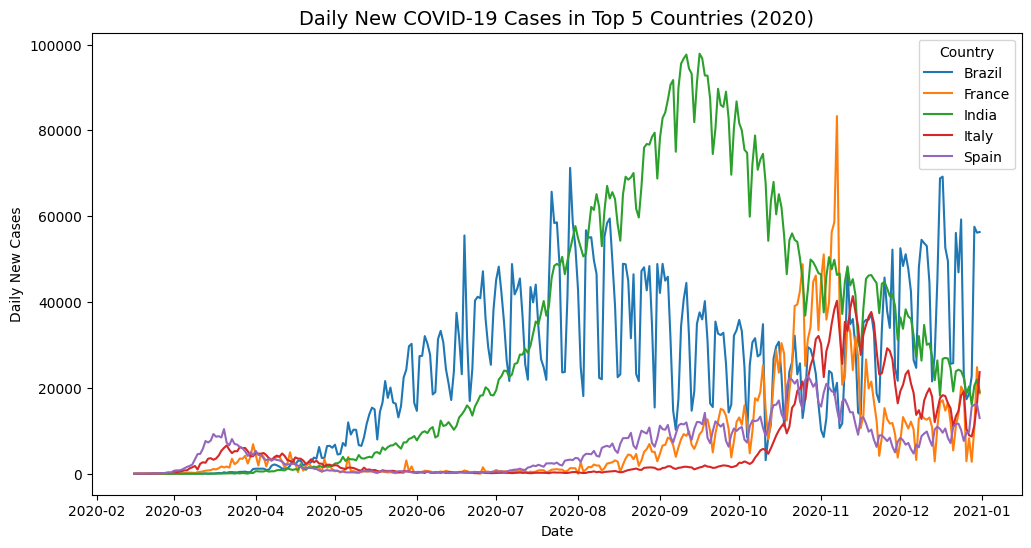

In [16]:
# ----- Visualization 1: Top 5 countries by cases -----

import matplotlib.pyplot as plt
import seaborn as sns

# Restrict to year 2020
analysis_2020 = analysis_df[analysis_df['date'].dt.year == 2020]

# Get top 5 countries by cumulative cases in 2020 (last available record per country)
top5_countries = (
    analysis_2020.groupby('country')['cumulative_total_cases']
    .max()
    .sort_values(ascending=False)
    .head(5)
    .index
)

print("Top 5 countries by cumulative cases in 2020:", list(top5_countries))

# Filter data for top 5
top5_data = analysis_2020[analysis_2020['country'].isin(top5_countries)]

# Plot daily new cases over time
plt.figure(figsize=(12,6))
sns.lineplot(
    data=top5_data,
    x='date', y='daily_new_cases',
    hue='country'
)
plt.title("Daily New COVID-19 Cases in Top 5 Countries (2020)", fontsize=14)
plt.xlabel("Date")
plt.ylabel("Daily New Cases")
plt.legend(title="Country")
plt.show()


Key Observations:

India shows the most dramatic surge, peaking around September 2020 with nearly 100,000 daily cases
Brazil had consistent high case counts throughout mid-2020, with peaks around 70,000 daily cases in July-August
European countries (France, Italy, Spain) show a different pattern with earlier peaks in March-April 2020, followed by a second wave in October-November
Timing differences: European countries were hit first (March-April), while India and Brazil saw their major surges later in the yea

# Visualization 2 — Cumulative Cases per 100,000 Population (2020)

To compare the relative impact of COVID-19 across countries, I will normalize cumulative case counts by population.
This allows us to see which countries were disproportionately affected relative to their population size, rather than just absolute numbers.

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to 

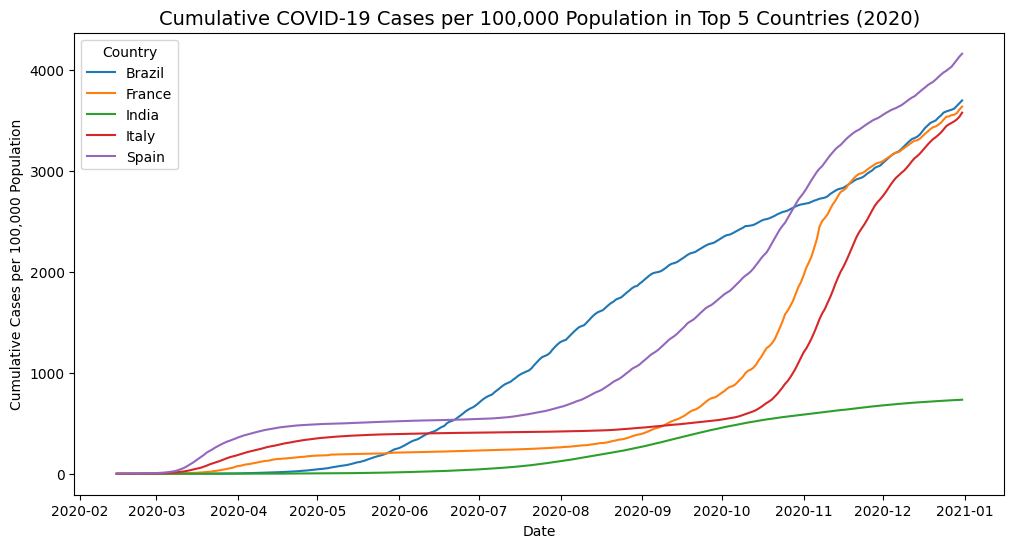

In [17]:
# ----- Visualization 2: Cases per 100k population -----

# Restrict to top 5 countries (from Visualization 1)
top5_data = analysis_2020[analysis_2020['country'].isin(top5_countries)].copy()

# Calculate cumulative cases per 100,000 population
top5_data['cases_per_100k'] = (
    top5_data['cumulative_total_cases'] / top5_data['Population_2020'] * 100000
)

# Plot cumulative cases per 100k over time
plt.figure(figsize=(12,6))
sns.lineplot(
    data=top5_data,
    x='date', y='cases_per_100k',
    hue='country'
)
plt.title("Cumulative COVID-19 Cases per 100,000 Population in Top 5 Countries (2020)", fontsize=14)
plt.xlabel("Date")
plt.ylabel("Cumulative Cases per 100,000 Population")
plt.legend(title="Country")
plt.show()


Key Observations:

Spain had the highest per capita impact, reaching over 4,000 cases per 100,000 people by end of 2020
France and Italy also show high per capita rates (around 3,500-3,700 per 100,000)
Brazil shows moderate per capita impact (around 2,500 per 100,000) despite high absolute numbers
India, despite having the highest absolute case counts, shows the lowest per capita impact (around 700 per 100,000)

Answer to Research Question:
The analysis reveals two distinct perspectives on COVID-19's global impact in 2020:
Absolute Impact: Countries with large populations (India, Brazil) naturally had higher total case counts and dominated global statistics. India's massive surge in September 2020 made it appear as the most affected country in raw numbers.
Relative Impact: When adjusted for population size, smaller European countries (Spain, France, Italy) were actually hit much harder relative to their populations. Spain's per capita rate was nearly 6 times higher than India's, despite India having far more total cases.
Geographic and Temporal Patterns: The data shows clear waves of transmission - Europe experienced early outbreaks (March-April 2020) and second waves (October-November), while large developing countries like India and Brazil saw their major surges during the middle months of 2020.
Key Insight: Raw case numbers can be misleading when comparing countries of vastly different population sizes. Population-adjusted metrics reveal that European countries bore a disproportionately heavy burden relative to their size, while countries like India, despite massive absolute numbers, had lower per capita infection rates.
This analysis demonstrates why both absolute and relative measures are essential for understanding pandemic impacts across different countries and populations.

# 5.2 Reflection

If I had more time to complete this project, I would:

Expand temporal analysis - Include 2021-2022 data to capture the full pandemic timeline including vaccination effects and variant impacts
Additional normalization factors - Explore cases per population density, GDP per capita, or healthcare capacity to better understand vulnerability factors
Death rate analysis - Perform similar analysis on mortality rates to understand not just infection spread but severity across countries
Statistical testing - Implement correlation analysis between population size, timing of outbreaks, and policy responses to identify significant relationships beyond visual patterns